### 트랜스포머 모형을 이용한 질의 응답

In [2]:
# Extractive QA : 책에서 문제의 답을 찾는다
# 각 단어가 답의 시작일 확률을 계산 ----> start_logits
# 각 단어가 답의 끝일 확률을 계산 ------> end_logits
# 가장 확률이 높은 구간을 선택 ---------> argmax

# Extraction QA 시각화
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 모델로드
MODEL_NAME = 'distilbert-base-cased-distilled-squad'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)


In [6]:
question = "What is the capital of France?"
context = "Paris is the capital and largest city of France. The city has a population of 2.1 million."

In [7]:
# 토크나이제이션
inputs = tokenizer(question, context, return_tensors='pt')

In [16]:
print(inputs)
# 101 : 시작
# 102 : 끝
print(tokenizer.decode(inputs['input_ids'][0]))

{'input_ids': tensor([[ 101, 1327, 1110, 1103, 2364, 1104, 1699,  136,  102, 2123, 1110, 1103,
         2364, 1105, 2026, 1331, 1104, 1699,  119, 1109, 1331, 1144,  170, 1416,
         1104,  123,  119,  122, 1550,  119,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}
[CLS] What is the capital of France? [SEP] Paris is the capital and largest city of France. The city has a population of 2. 1 million. [SEP]


In [22]:
# 토큰 리스트 : 입력데이터를 토큰화 한것 (단어쪼개기)
tokens = tokenizer.convert_ids_to_tokens( inputs['input_ids'][0] )
print(tokens[:])

['[CLS]', 'What', 'is', 'the', 'capital', 'of', 'France', '?', '[SEP]', 'Paris', 'is', 'the', 'capital', 'and', 'largest', 'city', 'of', 'France', '.', 'The', 'city', 'has', 'a', 'population', 'of', '2', '.', '1', 'million', '.', '[SEP]']


In [18]:
# 예측
with torch.no_grad():
    outputs = model(**inputs)
outputs  # start_logits, end_logits 보유

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-3.0939, -3.7486, -6.0080, -5.7086, -5.8702, -6.6693, -4.2987, -3.1756,
         -4.0037,  9.6050, -2.3164, -0.6722, -0.0465, -4.4179, -1.2335, -2.8592,
         -4.7219,  0.3473, -2.1641, -0.4413, -2.7191, -5.4559, -4.6687, -4.0404,
         -6.9446, -2.4015, -6.9144, -4.8101, -4.1148, -4.0998, -4.0035]]), end_logits=tensor([[-1.6628, -3.1275, -5.5114, -6.3964, -5.4165, -6.5068, -3.2359, -3.9798,
         -3.7454,  9.3340, -0.6415, -2.9119,  0.9548, -4.1359, -1.7446, -0.0305,
         -4.1837,  3.6947,  1.4507, -3.4107, -3.0052, -5.5297, -5.5761, -3.7925,
         -6.3793, -3.9835, -5.3027, -4.0287, -0.2574, -1.0193, -3.7452]]), hidden_states=None, attentions=None)

In [27]:
# logits을 확률로 변환
# outputs.start_logits.shape ---> torch.Size([1, 31])
# torch.softmax(outputs.start_logits, dim=-1) --> 상기 31에 대해서 softmax를 해야하므로 dim=1 또는 dim=-1 / 2차원
# torch.softmax(outputs.start_logits, dim=-1)[0] --> [0] 배치차원 제거. "배치 차원에서 첫 번째(유일한) 데이터 꺼내기"
# start_logits[0]은 배치 0번의 logit 전체를 의미
# start_logits[0] → [logit₀, logit₁, ..., logit₃₀] --> 즉, shape이 [31]이 된다.
# start_probs = torch.softmax(outputs.start_logits, dim=-1)[0].numpy() --> numpy 변환없이 pytorch 텐서 그대로 argmax해도 되는데, 시각화나 계산 사용때문에 .numpy()
# dim=0 배치방향(배치끼리 확률 비교), dim=1 또는 dim=-1은 토큰 방향(토큰들 중 어디가 정답인지)
start_probs = torch.softmax(outputs.start_logits, dim=-1)[0].numpy()  
end_probs = torch.softmax(outputs.end_logits, dim=-1)[0].numpy()

# 답변추출
# argmax --> start_logits 전체 중에서 가장 확률이 높은 토큰이 답의 시작의 위치임
answer_start = np.argmax(start_probs)
answer_end = np.argmax(end_probs) + 1   #+1은 왜하는데?
answer_tokens = tokens[answer_start:answer_end]
answer = tokenizer.convert_tokens_to_string(answer_tokens)

print(f' 모델의 답변 : {answer} ')
print(f' 시작위치 : {answer_start}, 토큰: {tokens[answer_start]}')
print(f' 종료위치 : {answer_end}, 토큰: {tokens[answer_end-1]}')
print(f' 신뢰도 : {start_probs[answer_start]*end_probs[answer_end-1]:.4f}')

 모델의 답변 : Paris 
 시작위치 : 9, 토큰: Paris
 종료위치 : 10, 토큰: Paris
 신뢰도 : 0.9953


In [33]:
# 상위 5개의 후보를 출력
print("질문과 유사한 상위 5개 후보 출력")
# 시작위치 상위 5개
# np.argsort(start_probs)[-5:][::-1] #2개 같음. 기본이 ascending 이므로. 간편하게 하려면 아래와같이 - 붙이기
top_start = np.argsort(-start_probs)[:5]
for i, idx in enumerate(top_start,1):
    print(f"시작위치 : {i} 토큰: {tokens[idx]} 확률: {start_probs[idx]}")

print("===================")

# 종료위치 상위 5개
top_end = np.argsort(-end_probs)[:5]
for i, idx in enumerate(top_end,1):
    print(f"종료위치 : {i} 토큰: {tokens[idx]} 확률: {end_probs[idx]}")


질문과 유사한 상위 5개 후보 출력
시작위치 : 1 토큰: Paris 확률: 0.9996964931488037
시작위치 : 2 토큰: France 확률: 9.534558193990961e-05
시작위치 : 3 토큰: capital 확률: 6.430949724745005e-05
시작위치 : 4 토큰: The 확률: 4.333172910264693e-05
시작위치 : 5 토큰: the 확률: 3.439987631281838e-05
종료위치 : 1 토큰: Paris 확률: 0.9955578446388245
종료위치 : 2 토큰: France 확률: 0.0035394502338021994
종료위치 : 3 토큰: . 확률: 0.00037531490670517087
종료위치 : 4 토큰: capital 확률: 0.0002285730151925236
종료위치 : 5 토큰: city 확률: 8.533219079254195e-05


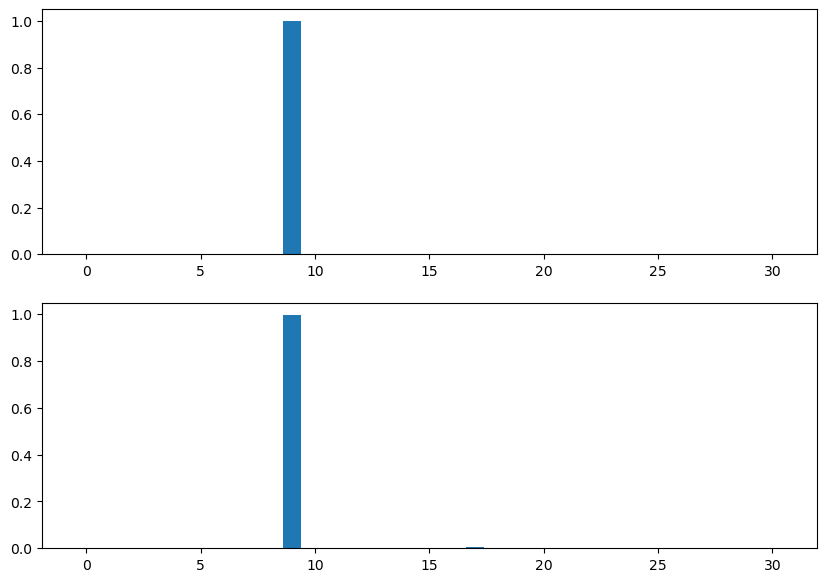

In [34]:
# 시각화
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,7))
ax1.bar(range(len(tokens)), start_probs)
ax2.bar(range(len(tokens)), end_probs)
plt.show()

In [ ]:
# 결론 : 
# 확률이 고르게 분산 --> 답을 못찾은 경우로 볼 수 있음. 
# 특정구간에 집중되면 --> 확신있는 답을 찾은 것으로 볼 수 있음.

<span style="font-size:13px">

### <span style="color: Gold"> offset mapping

- 토큰이 원문에서 몇 번째 글자에 있었는지 알려주는 표
- 예시
```
    - 문맥 : Paris is the capital of France.
             012345678901234 --> 문자인덱스
    - 토큰 : ['Paris', 'is', 'the', 'capital', 'of', 'France', '.']
                0        1      2       3       4       5       6  ------> 토큰인덱스
    - 모델은 토큰인덱스로 작동 (3번 토큰  'capital')
    - 답변위치는 문자인덱스 (13번째 문자부터 'capital' 시작)
    offsset_mapping = [
        (0,5),  # 토큰 0 : 'Paris'는 문자 0~5
        (6,8),  # 토큰 1 : 'is'는 문자 6~8
        (9,12),
        (13,20)
    ]
```
- 활용
    - 문자위치 --> 토큰 위치를 알수 있음 : Fine-tuning시 답변 레이블을 생성
    - 토큰위치 --> 문자 위치를 알수 있음 : 예측 결과를 원문에 매칭

In [50]:
# 토큰위치 <----> 문자 위치 변환을 직접 눈으로 확인할 수 있게 만든 예제
from transformers import AutoTokenizer
MODEL_NAME = 'distilbert-base-cased-distilled-squad'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
question = "What is AI?"
context = "Artificial Intelligence (AI) is the simulation of human intelligence in machines."
inputs = tokenizer(
    question,
    context,
    return_tensors = 'pt',
    return_offsets_mapping = True
)

# 토큰리스트
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
# print(tokens[:])
# print(inputs)
offset_mapping = inputs.offset_mapping[0].tolist()
# print(offset_mapping)

# 전체 텍스트 (질문+문맥)
full_text = question + context
print(full_text)

# 토큰별 위치 맵핑
print(f" {'인덱스':<8}{'토큰':<22}{'문자위치':<18}{'원문매칭'} ")
for idx, (token, (start, end)) in enumerate(zip(tokens, offset_mapping)):
        if start == end == 0:  # 특수 토큰
            matched_text = "[특수 토큰]"
            position = "N/A"
        else:
            # 원래 텍스트에서 추출
            matched_text = full_text[start:end]
            position = f"({start:3d}, {end:3d})"
        
        # 답변 영역 하이라이트
        highlight = "" if "AI" in token or "Intelligence" in token else "  "
        print(f"{idx:<8} {token:<25} {position:<18} '{matched_text}' {highlight}")


What is AI?Artificial Intelligence (AI) is the simulation of human intelligence in machines.
 인덱스     토큰                    문자위치              원문매칭 
0        [CLS]                     N/A                '[특수 토큰]'   
1        What                      (  0,   4)         'What'   
2        is                        (  5,   7)         'is'   
3        AI                        (  8,  10)         'AI' 
4        ?                         ( 10,  11)         '?'   
5        [SEP]                     N/A                '[특수 토큰]'   
6        Art                       (  0,   3)         'Wha'   
7        ##ific                    (  3,   7)         't is'   
8        ##ial                     (  7,  10)         ' AI'   
9        Intelligence              ( 11,  23)         'Artificial I' 
10       (                         ( 24,  25)         't'   
11       AI                        ( 25,  27)         'el' 
12       )                         ( 27,  28)         'l'   
13       is                  

In [55]:
# 실제 답변 위치
# 예를 들어, 답변이 하기와 같다면, 
answer = "Artificial Intelligence"
# 문맥에서 답변의 문자 위치 찾기
answer_start_char = context.index(answer)
answer_end_char = answer_start_char + len(answer)

# 문자위치 --> 토큰위치로 변환
answer_start_token = None
answer_end_token = None

# 질문부분 건너뛰기 (sequence_idf)
sequence_id = inputs.sequence_ids(0)# token_type_ids 를 대체하는게 sequence_ids 라 보면 됨
context_start_idx = sequence_id.index(1)# 첫번째 문맥의 시작

# 문맥에서 절대 위치를 계산하기 위해 질문 길이 보정
question_length = len(question) + 1 # +1은 공백을 의미
abs_answer_start = answer_start_char + question_length
abs_answer_end = answer_end_char + question_length
print(f"질문 길이 보정 + (question_length)")
print(f"절대문자위치 : {abs_answer_start} - {abs_answer_end}")

질문 길이 보정 + (question_length)
절대문자위치 : 12 - 35


In [59]:
for idx in range(context_start_idx, len(offset_mapping)):
  start, end = offset_mapping[idx]
  if start == end == 0:  # 특수 토큰 무시
      continue
  # 답변 시작 토큰 찾기
  if answer_start_token is None and end > abs_answer_start:
      answer_start_token = idx
      print(f"    시작 토큰 발견!")
      print(f"     인덱스: {idx}")
      print(f"     토큰: '{tokens[idx]}'")
      print(f"     오프셋: ({start}, {end})")
      print()

  # 답변 종료 토큰 찾기
  if answer_end_token is None and start >= abs_answer_end:
      answer_end_token = idx - 1
      print(f"    종료 토큰 발견!")
      print(f"      인덱스: {idx - 1}")
      print(f"      토큰: '{tokens[idx-1]}'")
      print(f"      오프셋: {offset_mapping[idx-1]}")
      break

  print("\n" + "="*80)
  print("최종 결과")
  print("="*80)

  if answer_start_token and answer_end_token:
    print(f"\n 변환 성공!")
    print(f"   토큰 위치: {answer_start_token} ~ {answer_end_token}")
    print(f"   토큰 리스트: {tokens[answer_start_token:answer_end_token+1]}")

    # 역변환 확인
    reconstructed = tokenizer.convert_tokens_to_string(
        tokens[answer_start_token:answer_end_token+1]
    )
    print(f"   복원된 텍스트: '{reconstructed}'")
    print(f"   원본 텍스트: '{answer}'")

    if answer.lower() in reconstructed.lower():
        print(f"\n   검증 성공! 완벽하게 매칭됩니다.")
    else:
        print(f"\n   부분 일치 (토크나이제이션으로 인한 차이)")
  else:
   print("\n 변환 실패 - 답변을 찾을 수 없습니다")


    #  Offset Mapping이란?
    #    각 토큰이 원본 텍스트의 어느 위치에 해당하는지 기록

    #  형식:
    #    [(start_char, end_char), ...]
    #    - start_char: 토큰 시작 문자 위치
    #    - end_char: 토큰 종료 문자 위치 (exclusive)

    # 변환 방법:
    #    1. 문자 위치 → 토큰 위치
    #       - offset_mapping을 순회
    #       - 문자 위치가 offset 범위 내에 있는 토큰 찾기

    #    2. 토큰 위치 → 문자 위치
    #       - offset_mapping[토큰_인덱스] 직접 참조

    # 주의사항:
    #    - 특수 토큰은 (0, 0)으로 표시
    #    - truncation으로 잘린 부분은 offset 없음
    #    - Fine-tuning 시 필수적으로 사용!

    # 활용:
    #    - SQuAD 데이터 전처리: 답변 문자 위치 → 토큰 위치
    #    - 예측 결과 해석: 토큰 위치 → 원문 매칭
    #    - 답변 검증: 예측한 토큰이 실제 답변과 일치하는지 확인



최종 결과

 변환 성공!
   토큰 위치: 9 ~ 14
   토큰 리스트: ['Intelligence', '(', 'AI', ')', 'is', 'the']
   복원된 텍스트: 'Intelligence ( AI ) is the'
   원본 텍스트: 'Artificial Intelligence'

   부분 일치 (토크나이제이션으로 인한 차이)

최종 결과

 변환 성공!
   토큰 위치: 9 ~ 14
   토큰 리스트: ['Intelligence', '(', 'AI', ')', 'is', 'the']
   복원된 텍스트: 'Intelligence ( AI ) is the'
   원본 텍스트: 'Artificial Intelligence'

   부분 일치 (토크나이제이션으로 인한 차이)

최종 결과

 변환 성공!
   토큰 위치: 9 ~ 14
   토큰 리스트: ['Intelligence', '(', 'AI', ')', 'is', 'the']
   복원된 텍스트: 'Intelligence ( AI ) is the'
   원본 텍스트: 'Artificial Intelligence'

   부분 일치 (토크나이제이션으로 인한 차이)

최종 결과

 변환 성공!
   토큰 위치: 9 ~ 14
   토큰 리스트: ['Intelligence', '(', 'AI', ')', 'is', 'the']
   복원된 텍스트: 'Intelligence ( AI ) is the'
   원본 텍스트: 'Artificial Intelligence'

   부분 일치 (토크나이제이션으로 인한 차이)

최종 결과

 변환 성공!
   토큰 위치: 9 ~ 14
   토큰 리스트: ['Intelligence', '(', 'AI', ')', 'is', 'the']
   복원된 텍스트: 'Intelligence ( AI ) is the'
   원본 텍스트: 'Artificial Intelligence'

   부분 일치 (토크나이제이션으로 인한 차이)

최종 결과

 변환 성공!
   토

In [ ]:
# SQuAD 데이터 전처리과정 살펴보기
# SQuAD 모델이 이해할 수 있는 형식으로 바꾸는 과정에 대한 이해
'''
{
   'question' : 'When was .....?',
   'context' : 'The Eiffel Tower ....',
   'answer' : {
        'text' : ["1889"],
        'answer_start' : [31]   ----> 문자위치
        }
}
'''
# 1. 토크나이제이션
# [CLS] When was ... [SEP] the eiffel tower .... [SEP]

# 2. 답변 문자 위치 확인 (예시)
ex_answer_start_char = 31
ex_answer_end_char = 35  #(31+len("1889"))

# 3. sequence_ids로 문맥 범위찾기
ex_context_range = [10,45]  # 토큰 10번 ~ 45번이 문맥

# 4. offset_mapping 으로 토큰위치 변환
ex_answer_start_token = 18   # 토크18번 = 1889의 시작
ex_answer_end_token = 19  # 토크19번 = 1889의 끝

# 5. 검증 : 답변이 문맥 내에 있으면 yes / truncate로 잘리지 않으면 yes

# 6. 최종 학습데이터 생성
'''
        {
        'input_ids' : ~~~
        'attention_mask' : ~~
        'start_positions' : 18,
        'end_positions' :19
        }
'''


In [ ]:
from transformers import AutoTokenizer
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# SQuAD 데이터 샘플
sample = {
    "question": "When was the Eiffel Tower built?",
    "context": "The Eiffel Tower was built in 1889 for the Paris World's Fair. It was designed by Gustave Eiffel and remains one of the most iconic structures in the world.",
    "answers": {
        "text": ["1889"],
        "answer_start": [31]  # "1889"의 문자 시작 위치
    }
}

# 1.  토크나이제이션
inputs = tokenizer(
    sample['question'],
    sample['context'],
    max_length = 384,
    truncation = 'only_second', #문맥만 자르기
    return_offsets_mapping = True, #오프셋 맵핑,
    return_tensors = 'pt',
    padding = 'max_length'   # 최대길이로 패딩
)
inputs

tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
print(f'총 토큰수 : {len(tokens)}')   # max_length와 동일
print(f" 실제 : {inputs['attention_mask'][0].tolist().count(1)}")  #count를 위해서 tensor에 count가 없어서 tolist 변환하고 count함
print(f" 패딩 : {inputs['attention_mask'][0].tolist().count(0)}")  #총 토큰수 384-49 ==> 패딩

총 토큰수 : 384
 실제 : 49
 패딩 : 335


In [84]:
# 답변 문자위치 확인
answer_text = sample['answers']['text'][0]
answer_start_char = sample['answers']['answer_start'][0]
answer_end_char = answer_start_char + len(answer_text)
print(f'답변 텍스트 : {answer_text}')
print(f'답변 시작 : {answer_start_char}')
print(f'답변 종료 : {answer_end_char}')
print(f'검증 : {sample["context"][answer_start_char:answer_end_char]}')

답변 텍스트 : 1889
답변 시작 : 31
답변 종료 : 35
검증 : 889 


In [82]:
# sequence_ids로 문맥 범위 찾기
# token_type_ids 와 유사해서 문장의 종류를 가지고 있음. 0:질문, 1:문장, None:특수토큰 또는 패딩
sequence_ids=inputs.sequence_ids(0)

# 문맥의 시작과 끝
context_start = sequence_ids.index(1)
context_end = len(sequence_ids) - sequence_ids[::-1].index(1)-1

print(f" 특수토큰 : {sequence_ids.count(None)}")
print(f" 0 질문 : {sequence_ids.count(0)}")
print(f" 1 문맥 : {sequence_ids.count(1)} ")
print(f"문맥 시작: {context_start}")
print(f" 문맥종료: {context_end}")
print(f"문맥 첫번째 토큰 : {tokens[context_start]}")
print(f" 문맥 마지막 토큰 : {tokens[context_end]}")


 특수토큰 : 338
 0 질문 : 9
 1 문맥 : 37 
문맥 시작: 11
 문맥종료: 47
문맥 첫번째 토큰 : the
 문맥 마지막 토큰 : .
